In [1]:
#This is code to start running the model.  You don't need to interact with this
from pulp import *
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly
import plotly.graph_objs as go
import plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#plotly.offline.init_notebook_mode()
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# fix parameters

truck_usage = 1800
transport_tarif = 52
variable_wh_cost = 20

#Name of fields in objects dictionary
Name = 0
City = 1
Latitude = 2
Longtitude = 3
Demand = 4

Fix_cost_fed = 300000000
Fix_cost_reg = 160000000

# tuning of Map output vision

# Determines the set of locations used to match entries in `locations` to regions on the map.
## options ("ISO-3" | "USA-states" | "country names")
locationmode = 'ISO-3'

#set scope of map
## options ("world" | "usa" | "europe" | "asia" | "africa" | "north america" | "south america")
scope = 'world'

# Sets the projection type.
## options ("equirectangular" | "mercator" | "orthographic" | "natural earth" | "kavrayskiy7" |
## "miller" | "robinson" | "eckert4" | "azimuthal equal area" | "azimuthal equidistant" | "conic equal area" |
## "conic conformal" | "conic equidistant" | "gnomonic" | "stereographic" | "mollweide" | "hammer" |
## "transverse mercator" | "albers usa" | "winkel tripel" | "aitoff" | "sinusoidal")
projection = "kavrayskiy7"

# Determines the mode of hover interactions. If `clickmode` includes the "select" flag, `hovermode` defaults to "closest".
# If `clickmode` lacks the "select" flag, it defaults to "x" or "y" (depending on the trace's `orientation` value)
# for plots based on cartesian coordinates. For anything else the default value is "closest".
## options ("x" | "y" | "closest" | False)
hovermode = False

# Determines whether or not a layout width or height that has been left undefined by the user is initialized
# on each relayout. Note that, regardless of this attribute, an undefined layout width or height is always
# initialized on the first call to plot.
## options (boolean)
autosize = True

In [3]:
def get_data(file_obj='./input/Objects.csv',
             file_distance = './input/Distance_matrix.csv',
             sep = ';',
             index_obj = 'Name',
             index_distance = 'City'):
    
    file_obj = file_obj
    file_distance = file_distance
    sep = sep
    index_obj = index_obj
    index_distance = index_distance
    
    df_obj_csv = pd.read_csv(file_obj, sep=sep, index_col=index_obj)
    df_distance_csv = pd.read_csv(file_distance, sep=sep, index_col=index_distance)
    
    Objects = df_obj_csv.index
    
    DC_param = {'Fed': [Fix_cost_fed, df_obj_csv['Demand'].sum() / truck_usage],
                'Reg': [Fix_cost_reg, df_obj_csv['Demand'].sum() / truck_usage / 2]}
    
    Transport_cost = {}
    for w in Objects:
        for c in Objects:
            Transport_cost[(w, c)] = df_distance_csv.loc[w, c] * transport_tarif
    
    return(df_obj_csv, df_distance_csv, Objects, DC_param, Transport_cost)

In [4]:
def optimization_model(df_obj_csv,
                       df_distance_csv,
                       Objects,
                       DC_param,
                       Transport_cost,
                       demand_increments=1.0,
                       print_status=True,
                       fix_cost_ratio=1.0,
                       scenario_name='SC_network'):
    
    DC_param = {'Fed': [Fix_cost_fed * fix_cost_ratio, (df_obj_csv['Demand'].sum() * demand_increments) / truck_usage],
                'Reg': [Fix_cost_reg * fix_cost_ratio, (df_obj_csv['Demand'].sum() * demand_increments) / truck_usage / 2]}
    
    # Initialize
    model = LpProblem(name=scenario_name, sense=LpMinimize)
    
    # Define Decision Variables
    
    # Define Supply Chain Channels
    SC_channels = LpVariable.dicts('DC_Cust_channel',
                                   [(w, c) for w in Objects for c in Objects],
                                   lowBound=0,
                                   cat='Continous')
    # Define DC status
    DC_status = LpVariable.dicts('DC_status',
                                 [(w, s) for w in Objects for s in DC_param.keys()],
                                 cat='Binary')
    
    # Define objective
    model += (lpSum([DC_param[s][0] * DC_status[(w, s)]] for w in Objects for s in DC_param.keys())
             + lpSum([Transport_cost[(w, c)] * SC_channels[(w, c)]] for w in Objects for c in Objects))
    

    # Define the Constraints

    # Define Demand == Total Shipments
    for c in Objects:
        model += lpSum([SC_channels[(w, c)] for w in Objects]) == ((df_obj_csv.loc[c, 'Demand'] * demand_increments) / truck_usage)

    # Define DC
    #if there is a flow from a warehouse, it should be opened    
    for w in Objects:
        model += lpSum([SC_channels[w, c] for c in Objects]) <= lpSum([DC_status[(w, s)] * DC_param[s][1] for s in DC_param.keys()])
    
    # Solve Model
    model.solve()
    
    #create DF Output
    
    #Channels
    output_channels = []
    for w in Objects:
        o = [SC_channels[(w, c)].varValue for c in Objects]
        output_channels.append(o)
    df_output_channels = pd.DataFrame.from_records(output_channels, columns=Objects)
    df_output_channels['Name'] = Objects
    df_output_channels.set_index('Name', inplace=True)
    
    #DCs
    #full list of DC with status
    output_dc = []
    for w in Objects:
        dc = [DC_status[w, s].varValue for s in DC_param.keys()]
        output_dc.append(dc)
    df_output_dc = pd.DataFrame.from_records(output_dc, index=Objects, columns=DC_param.keys())
    
    #short list of define DC
    wh_loc = []
    for w in df_output_dc.index:
        for s in df_output_dc:
            if df_output_dc.loc[w][s] > 0:
                wh_loc.append(w)
    
    #calculation of transport cost by DC
    transport_cost_dc = (df_output_channels * df_distance_csv * transport_tarif).sum(axis=1)
    
    #short list of flows define by model
    total_flow_wc = {(w, c): SC_channels[w, c].varValue for w in Objects
                                                        for c in Objects
                                                            if SC_channels[w, c].varValue > 0}
    #dataset for map with sc_channels
    customers_assignment = []
    maps_assign_wc = {}
    for (w, c) in total_flow_wc.keys():
            cust = {
                'Warehouse':str(df_obj_csv.loc[w]['City']),
                'Customer':str(df_obj_csv.loc[c]['City']),
                'Customer Demand': total_flow_wc[w, c],
                'Distance': df_distance_csv.loc[w][c],
                'Warehouse Latitude' : df_obj_csv.loc[w]['Latitude'],
                'Warehouse Longitude' : df_obj_csv.loc[w]['Longtitude'],
                'Customers Latitude' : df_obj_csv.loc[c]['Latitude'],
                'Customers Longitude': df_obj_csv.loc[c]['Longtitude']
            }
            customers_assignment.append(cust)
            if (w, c) not in maps_assign_wc:
                maps_assign_wc[w, c] = 1
    
    #dataset for map with the wh_opened
    opened_warehouses = []
    for w in wh_loc:
        wh = {'Warehouse City':df_obj_csv.loc[w]['City'],
              'Lat':df_obj_csv.loc[w]['Latitude'],
              'Lon':df_obj_csv.loc[w]['Longtitude'],
              'Total Demand to Warehouse':df_output_channels.sum(axis=1)[w]
        }
        opened_warehouses.append(wh)
    
    #Print on display
    if print_status == True:
        print(f'Status :{LpStatus[model.status]}')
        print(f'Objective = {value(model.objective)}\n')
        for w in df_output_dc.index:
            for s in df_output_dc:
                if df_output_dc.loc[w][s] > 0:
                    print(f'{w: <20} - {s: >15} - cost: {DC_param[s][0]: >15}')
        print(f'Number of DCs: \n{df_output_dc.sum()}\n')
        print('Transport cost by sites:\n')
        print(f'{transport_cost_dc[transport_cost_dc > 0].astype(int)}\
              \nTotal: {transport_cost_dc[transport_cost_dc > 0].sum().astype(int)}')
    
    #write to file
    
    df_wh = pd.DataFrame.from_records(opened_warehouses)
    df_wh = df_wh[['Warehouse City', 'Total Demand to Warehouse']]
    
    df_cu = pd.DataFrame.from_records(customers_assignment)
    df_cu_copy = df_cu.copy()
    df_cu = df_cu[['Warehouse', 'Customer', 'Distance', 'Customer Demand']]
    
#     writer = pd.ExcelWriter(scenario_name+'_detailed.xlsx')    
#     df_wh.to_excel(writer,'Opened_Warehouses',index=False)
#     df_cu.to_excel(writer,'Customers Assignment',index = False)
    
    return(model, df_output_channels, df_output_dc, wh_loc, df_cu_copy)

In [5]:
# In this function, we are visualizaing the output data-- the data after the optimization has run
def output_visual(Objects,
                  df_obj_csv,
                  df_cu,
                  wh_loc,
                  scenario_name='SC_network'):   
    warehouse_list = []
    for w in wh_loc:
            wh = {
                        'text':'Warehouse-' + df_obj_csv.loc[w]['City'],
                        'lat':df_obj_csv.loc[w]['Latitude'],
                        'long':df_obj_csv.loc[w]['Longtitude'],
                        'cnt':10000000,
                        'size' : 10,
                        'color' : 'rgba(0, 100, 0)'
                        }
            warehouse_list.append(wh)    

    customer_list =[] 
    for c in Objects:
        cust = {
            'text':'Customer-' + df_obj_csv.loc[c]['City'],
            'lat':df_obj_csv.loc[c]['Latitude'],
            'long':df_obj_csv.loc[c]['Longtitude'] ,
            'cnt':10000000,
            'size' : df_obj_csv.loc[c]['Demand'] / 1000000, #5,
            'color' : 'yellow' #'rgb(255, 0, 0)'
        }
        customer_list.append(cust)


    df = pd.DataFrame.from_records(warehouse_list)
    df['shape'] =  "triangle-down"
    df_cust = pd.DataFrame.from_records(customer_list)
    df_cust['shape'] =  "circle"
    df = df.append(df_cust, ignore_index = True) 

    df_cu['lane'] = df_cu.apply(lambda x: str(x['Warehouse'])+'-'+str(x['Customer']),axis=1)

    list_dict = {'warehouses':df, 'customers':df_cust}

    outbound_locations=[]
    for key, i in list_dict.items():
        location = dict(
            type = 'scattergeo',
            locationmode = locationmode,
            lon = i['long'],
            lat = i['lat'],
            text =i['text'],
            marker = dict(
                size = i['size'],
                # sizeref = 2. * max(df_sub['pop']/scale) / (25 ** 2),
                symbol = i['shape'],
                color = i['color'],
                line = dict(
                    width=3,
                    color='rgba(68, 68, 68, 0)'
                )),
            name = key)
        outbound_locations.append(location)

    inbound_paths = []
    outbound_paths = []

    for i in range( len( df_cu) ):
            outbound_paths.append(
                dict(
                    type = 'scattergeo',
                    locationmode = locationmode,
                    lon = [ df_cu['Warehouse Longitude'][i], df_cu['Customers Longitude'][i] ],
                    lat = [ df_cu['Warehouse Latitude'][i], df_cu['Customers Latitude'][i] ],
                    mode = 'lines',
                    line = dict(
                        width = df_cu['Customer Demand'][i] / 500,#  1,
                        color = 'red',
                    ),
                    opacity = 0.8,
                    name = df_cu['lane'][i],
                    showlegend = False
                )
            )  

    layout = dict(
        title = 'Optimal_solution',
        showlegend = True,
        hovermode=hovermode,
        autosize = autosize,
        height = 500,
        width = 900,
        geo = dict(
            scope=scope,
            projection=dict( type=projection ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
            lataxis = go.layout.geo.Lataxis(
                range = [40, 80],
                showgrid = True,
                dtick = 10
            ),
            lonaxis = go.layout.geo.Lonaxis(
                range = [20, 120],
                showgrid = True,
                dtick = 10
            ),
        )
    )
    
    iplot({"data":outbound_locations+outbound_paths, "layout":layout},filename=scenario_name+'_outbound.html')

In [6]:
def sankey_plot(Objects,
                wh_loc,
                df_cu):
    
    # nodes
    nodes = {}
    n = 0
    for w in wh_loc:
                        #'Label', 'City', ID, color(rgb)
        nodes['DC_'+ w] = ['DC', w, n, f'rgb(200,100,{(n + 1) * 50})']
        n += 1
    for c in Objects:
        nodes[c] = ['Store', c, n, f'rgb(200,200,{(n + 1) * 10})']
        n += 1

    label = list(nodes.keys())

    color = []
    for key in nodes:
        color.append(nodes[key][3])

    #links
    source = []
    for w in df_cu['Warehouse']:
        source.append(nodes['DC_'+w][2])
    target = []
    for c in df_cu['Customer']:
        target.append(nodes[c][2])
    value = np.array(df_cu['Customer Demand'])

    data_trace = dict(type='sankey',
                      domain = dict(x =  [0,1], y =  [0,1]),
                      orientation = "h",
                      valueformat = ".0f",
                      node = dict(pad = 10,
                                  thickness = 30,
                                  line = dict(color = "black", width = 0.5),
                                  label =  label,
                                  color = color),
                      link = dict(source = source,
                                  target = target,
                                  value = value,))
    layout =  dict(title = "Optimum goods movement",
                   height = 700,
                   width = 1000,
                   font = dict(size = 10),)
    fig = dict(data=[data_trace], layout=layout)
    iplot(fig, validate=False)

In [7]:
def run():
    # collect data
    df_obj_csv, df_distance_csv, Objects, DC_param, Transport_cost = get_data()

    #solve model
    model, df_output_channels, df_output_dc, wh_loc, df_cu = optimization_model(df_obj_csv, df_distance_csv, Objects, DC_param, Transport_cost)

    #plot map
    output_visual(Objects, df_obj_csv, df_cu, wh_loc)

    #plot sankey
    sankey_plot(Objects, wh_loc, df_cu)

In [8]:
run()

Status :Optimal
Objective = 1272940595.37176

Saint-Peterburg      -             Reg - cost:     160000000.0
Tumeni               -             Reg - cost:     160000000.0
Moscow               -             Reg - cost:     160000000.0
Krasnodar            -             Reg - cost:     160000000.0
Number of DCs: 
Fed    0.0
Reg    4.0
dtype: float64

Transport cost by sites:

Name
Saint-Peterburg    111811237
Tumeni             301174541
Moscow             147331787
Krasnodar           72623027
dtype: int32              
Total: 632940595


In [9]:
# Checking model for demand variation
df_obj_csv, df_distance_csv, Objects, DC_param, Transport_cost = get_data()

models_obj = []
warehouse_var = []
var = {}
for i in range(5, 50):
    demand_increments = i / 10
    model, df_output_channels, df_output_dc, wh_loc, df_cu = optimization_model(df_obj_csv, 
                                                                                df_distance_csv,
                                                                                Objects,
                                                                                DC_param,
                                                                                Transport_cost,
                                                                                demand_increments,
                                                                                False)
    print(f'demand_increments = {demand_increments: >3,.1f} Number od DC :{len(wh_loc): >2,.0f}')
    var[demand_increments] = len(wh_loc)
    models_obj.append(value(model.objective))
    warehouse_var.append(wh_loc)

df_obj = pd.DataFrame(models_obj)
df_wh_var = pd.DataFrame(warehouse_var)
df_var = pd.DataFrame.from_dict(var, orient='index')


demand_increments = 0.5 Number od DC : 3
demand_increments = 0.6 Number od DC : 3
demand_increments = 0.7 Number od DC : 4
demand_increments = 0.8 Number od DC : 4
demand_increments = 0.9 Number od DC : 4
demand_increments = 1.0 Number od DC : 4
demand_increments = 1.1 Number od DC : 4
demand_increments = 1.2 Number od DC : 5
demand_increments = 1.3 Number od DC : 5
demand_increments = 1.4 Number od DC : 5
demand_increments = 1.5 Number od DC : 5
demand_increments = 1.6 Number od DC : 5
demand_increments = 1.7 Number od DC : 5
demand_increments = 1.8 Number od DC : 5
demand_increments = 1.9 Number od DC : 5
demand_increments = 2.0 Number od DC : 5
demand_increments = 2.1 Number od DC : 5
demand_increments = 2.2 Number od DC : 5
demand_increments = 2.3 Number od DC : 5
demand_increments = 2.4 Number od DC : 5
demand_increments = 2.5 Number od DC : 5
demand_increments = 2.6 Number od DC : 5
demand_increments = 2.7 Number od DC : 5
demand_increments = 2.8 Number od DC : 5
demand_increment

In [10]:
df_wh_var

,0,1,2,3,4,5,6,7
0,Saint-Peterburg,Tumeni,Moscow,None,None,None,None,None
1,Saint-Peterburg,Tumeni,Moscow,None,None,None,None,None
2,Saint-Peterburg,Tumeni,Moscow,Krasnodar,None,None,None,None
3,Saint-Peterburg,Tumeni,Moscow,Krasnodar,None,None,None,None
4,Saint-Peterburg,Tumeni,Moscow,Krasnodar,None,None,None,None
5,Saint-Peterburg,Tumeni,Moscow,Krasnodar,None,None,None,None
6,Saint-Peterburg,Tumeni,Moscow,Krasnodar,None,None,None,None
7,Saint-Peterburg,Krasnoyarsk,Yekatherinburg,Moscow,Krasnodar,None,None,None
8,Saint-Peterburg,Krasnoyarsk,Yekatherinburg,Moscow,Krasnodar,None,None,None
9,Saint-Peterburg,Krasnoyarsk,Yekatherinburg,Moscow,Krasnodar,None,None,None


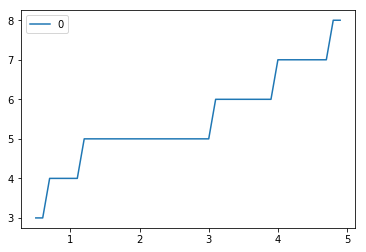

In [11]:
df_var.plot()

In [12]:
import plotly.plotly as py
data = [go.Scatter(
    x = list(df_var.index),
    y = list(df_var[0])
)]

layout = go.Layout(title='Количество складов в зависимости от роста объема спроса',
                  yaxis=dict(title='Количество складов'),
                  xaxis=dict(title='Индекс прироста спроса от текущего'))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [13]:
# Checking model for fix_cost of DC
df_obj_csv, df_distance_csv, Objects, DC_param, Transport_cost = get_data()

models_obj = []
warehouse_var = []
var = {}
for i in range(1, 50):
    fix_cost_ratio = i / 10
    model, df_output_channels, df_output_dc, wh_loc, df_cu = optimization_model(df_obj_csv, 
                                                                                df_distance_csv,
                                                                                Objects,
                                                                                DC_param,
                                                                                Transport_cost,
                                                                                1.0,
                                                                                False,
                                                                                fix_cost_ratio)
    print(f'Fix cost ratio = {fix_cost_ratio: >3,.1f}: Number od DC :{len(wh_loc): >3,.0f}')
    var[fix_cost_ratio] = len(wh_loc)
    models_obj.append(value(model.objective))
    warehouse_var.append(wh_loc)

df_obj = pd.DataFrame(models_obj)
df_wh_var = pd.DataFrame(warehouse_var)
df_var = pd.DataFrame.from_dict(var, orient='index')

Fix cost ratio = 0.1: Number od DC : 13
Fix cost ratio = 0.2: Number od DC :  8
Fix cost ratio = 0.3: Number od DC :  6
Fix cost ratio = 0.4: Number od DC :  5
Fix cost ratio = 0.5: Number od DC :  5
Fix cost ratio = 0.6: Number od DC :  5
Fix cost ratio = 0.7: Number od DC :  5
Fix cost ratio = 0.8: Number od DC :  5
Fix cost ratio = 0.9: Number od DC :  5
Fix cost ratio = 1.0: Number od DC :  4
Fix cost ratio = 1.1: Number od DC :  4
Fix cost ratio = 1.2: Number od DC :  4
Fix cost ratio = 1.3: Number od DC :  4
Fix cost ratio = 1.4: Number od DC :  4
Fix cost ratio = 1.5: Number od DC :  3
Fix cost ratio = 1.6: Number od DC :  3
Fix cost ratio = 1.7: Number od DC :  3
Fix cost ratio = 1.8: Number od DC :  3
Fix cost ratio = 1.9: Number od DC :  3
Fix cost ratio = 2.0: Number od DC :  3
Fix cost ratio = 2.1: Number od DC :  3
Fix cost ratio = 2.2: Number od DC :  3
Fix cost ratio = 2.3: Number od DC :  3
Fix cost ratio = 2.4: Number od DC :  3
Fix cost ratio = 2.5: Number od DC :  3


In [14]:
import plotly.plotly as py
data = [go.Scatter(
    x = list(df_var.index),
    y = list(df_var[0])
)]

layout = go.Layout(title='Количество складов в зависимости от роста индекса цен на склад',
                  yaxis=dict(title='Количество складов'),
                  xaxis=dict(title='Индекс прироста стоимости склада'))

fig = go.Figure(data=data, layout=layout)

iplot(fig)

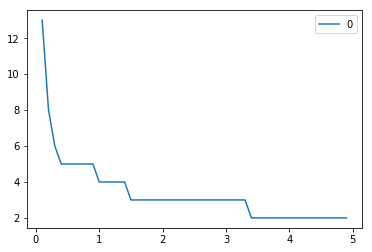

In [15]:
df_var.plot()